In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
using Zygote, Lux, ComponentArrays, Plots, QuadGK, Interpolations, Optimisers, NNlib
using Random: Xoshiro
using MLUtils: DataLoader

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


In [3]:
using PhasorNetworks

# Load the dataset

In [4]:
include("pixel_data.jl")

interpolate_roc (generic function with 1 method)

In [5]:
using Base: @kwdef

In [6]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 128    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [7]:
args = Args(batchsize = 128)

Args(0.0003, 128, 10, false)

In [8]:
data_dir = "pixel_data/"

"pixel_data/"

In [9]:
file_pairs = get_dataset(data_dir)

10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [10]:
q, ylocal, pt = get_samples(file_pairs[1:2])

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [11]:
q_test, ylocal_test, pt_test = get_samples(file_pairs[3:3]);

In [12]:
q |> size

(20, 13, 21, 99991)

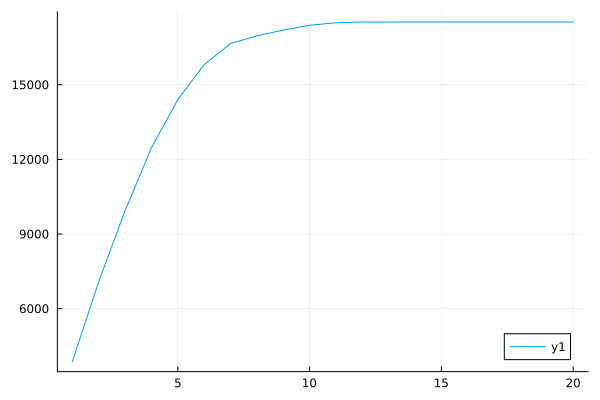

In [13]:
plot(sum(q[:,:,:,128], dims=(2,3)) |> vec)

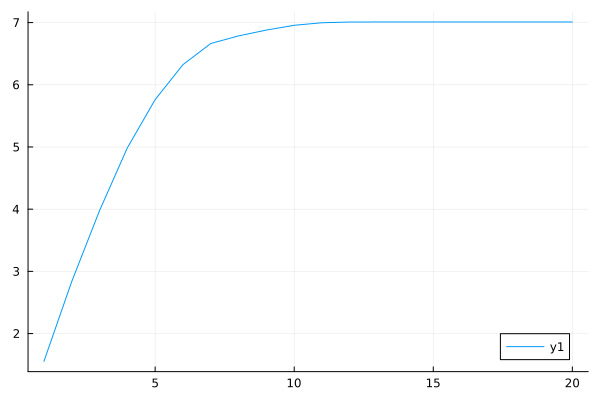

In [14]:
plot(sum(scale_charge(q[:,:,:,128]), dims=(2,3)) |> vec)

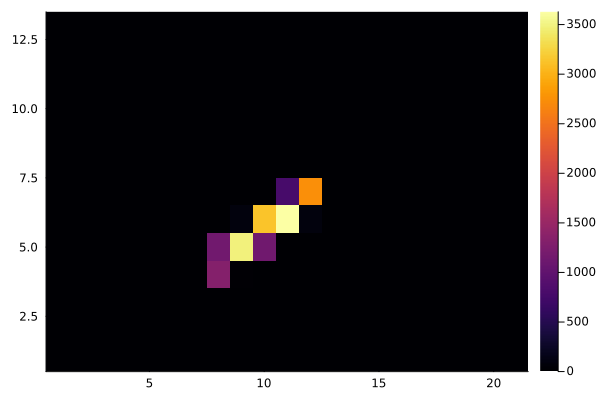

In [15]:
heatmap(q[12,:,:,128])

In [16]:
ylocal |> size

(99991,)

In [17]:
pt |> size

(99991,)

In [18]:
train_loader = DataLoader((q, ylocal, pt), batchsize=args.batchsize)

782-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [19]:
test_loader = DataLoader((q_test, ylocal_test, pt_test), batchsize=args.batchsize)

391-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [20]:
x, xl, y = first(train_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [21]:
x |> size

(20, 13, 21, 128)

In [22]:
n_px = size(x, 2) 
n_in = n_px + 1

14

# Set up the model

In [23]:
function process_inputs(x, y_local)
    x = scale_charge(x)
    x = sum(x, dims=(1,3))
    n_batch = size(x, 4)
    x = reshape(x, (n_px, n_batch))
    y_local = reshape(y_local, (1, n_batch))

    x = cat(x, y_local, dims = 1)
    return x
end

process_inputs (generic function with 1 method)

In [24]:
process_inputs(x, xl)

14×128 Matrix{Float64}:
  0.0       0.0       0.0       0.0      …   0.0       0.0        0.0
  0.0       0.00728   0.0       0.0          0.0       0.0002     0.0
  0.01548   3.89436   0.04744   0.02484      0.0       0.89496    0.02688
  4.53608  22.421     5.53156  10.3167       0.0      45.6419     8.18032
 13.0276   28.691    14.8939   42.2308       0.08     88.6978    38.3292
 18.1824   29.1889   21.668    39.5168   …  17.8984   40.6906    50.7078
 17.2391   11.8402   24.0816   74.3496      49.9682   -1.49488   27.1796
 12.8535   -0.58136   8.4348   -3.04328      0.58264   0.0       -1.61592
  7.73868   0.0      -0.44068  -0.00316     -0.19872   0.0        0.0
 -0.07108   0.0       0.0       0.0         -0.0002    0.0        0.0
  0.0       0.0       0.0       0.0      …   0.0       0.0        0.0
  0.0       0.0       0.0       0.0          0.0       0.0        0.0
  0.0       0.0       0.0       0.0          0.0       0.0        0.0
 -6.94104  -4.33669  -7.79379  -2.67448      

In [25]:
model = Chain(
    BatchNorm(n_in),
    x -> tanh.(x),
    PhasorDense(n_in => 128),
    PhasorDense(128 => 3) 
)

Chain(
    layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
    layer_2 = WrappedFunction{:direct_call}(var"#35#36"()),
    layer_3 = PhasorDense((14, 128)),   # 1_920 parameters
    layer_4 = PhasorDense((128, 3)),    # 387 parameters
)         # Total: 2_335 parameters,
          #        plus 29 states.

In [26]:
rng0 = Xoshiro(42)
ps, st = Lux.setup(rng0, model)

((layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.011489658 0.12606403 … 0.0047437637 -0.13452569; -0.09446841 0.07400124 … 0.07980053 -0.13867775; … ; 0.10672839 -0.16736038 … -0.10951539 -0.05882632; 0.052183025 -0.08769705 … 0.07845488 -0.18887484], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]), layer_4 = (weight = Float32[0.5993126 0.4167722 … -0.218614 0.34311864; -0.12842335 -0.9040824 … 0.2625846 0.21363495; 0.3049119 -0.8346293 … -0.7711599 1.7686664], bias = ComplexF32[1.0f0 + 0

In [27]:
rng0

Xoshiro(0xf0bc749b695a7f4b, 0x4ae160faba775156, 0x459acbcc86294012, 0x893d8ee272d97c34, 0xc90c4a0730db3f7e)

In [28]:
ps.layer_3.weight

128×14 Matrix{Float32}:
 -0.0114897    0.126064     0.107674   …   0.00474376  -0.134526
 -0.0944684    0.0740012   -0.02655        0.0798005   -0.138678
  0.0417715   -0.0387155    0.0670196     -0.114585    -0.0710165
 -0.0465299    0.00768007  -0.0214743     -0.127171    -0.0771429
  0.0440904    0.116618    -0.0610862     -0.0713483    0.0893507
 -0.0650848   -0.00706382   0.056637   …  -0.161191     0.163324
 -0.109227    -0.0373962    0.183448       0.0467173   -0.0205643
 -0.0973022    0.208089    -0.0875202      0.0462605   -0.128172
 -0.183464     0.013321    -0.041912       0.0595856    0.0762518
  0.00680964  -0.107499    -0.0521376     -0.0854929   -0.0669989
  0.00593104   0.0982831    0.0881761  …   0.027704    -0.207907
 -0.00427762   0.0605813    0.098071      -0.0828638    0.0331616
  0.113663    -0.14724      0.103175      -0.144265     0.142832
  ⋮                                    ⋱               
 -0.0492727   -0.145522     0.0868463      0.25479      0.00487026
 

In [29]:
rng1 = Xoshiro(52)
ps2, st2 = Lux.setup(rng1, model)

((layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.07469728 -0.012076104 … 0.076444544 0.031037284; -0.03738938 -0.19151646 … -0.009529602 0.02548344; … ; 0.06077329 0.0080784 … -0.0046129944 0.025787555; -0.111760974 -0.029442368 … 0.17659022 -0.091173895], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]), layer_4 = (weight = Float32[-0.112349935 -1.2754613 … -0.64246917 -0.14267664; 0.53941774 -0.92033273 … 1.3525789 -0.16396828; -0.40584895 1.428268 … 0.04730248 0.0032281957], bias = Comp

In [30]:
rng1

Xoshiro(0xba99330e3630d158, 0x67781edeb7501b18, 0xa8748d53309733fe, 0x27e124338437edb9, 0x27cf51e98df84d4b)

In [31]:
ps2.layer_3.weight

128×14 Matrix{Float32}:
 -0.0746973   -0.0120761    0.196232    …   0.0764445    0.0310373
 -0.0373894   -0.191516     0.0547912      -0.0095296    0.0254834
  0.0361047    0.13358     -0.0162071       0.118566    -0.068913
 -0.127205    -0.0850498    0.127752        0.128518    -0.0106375
  0.107294    -0.0244415   -0.0618268      -0.112867    -0.0351434
  0.118073     0.00894314  -0.125909    …   0.0803719   -0.0095916
 -0.0526642   -0.0110196   -0.0638349       0.157711    -0.0871786
 -0.00240561   0.028503     0.220775        0.095637    -0.0659894
  0.19188     -0.0356622   -0.0243945      -0.0482014   -0.0300401
 -0.156727     0.0654233   -0.110213        0.0562429   -0.0353402
 -0.0366579   -0.0281954    0.0314815   …  -0.122495    -0.127144
 -0.0783345    0.0837709    0.0251527       0.0543067    0.0782351
  0.237112     0.0014809    0.191229       -0.0536659   -0.00860514
  ⋮                                     ⋱               
  0.0933223   -0.138258    -0.162436       -0.001

In [32]:
y_naive, _ = model(process_inputs(x, xl), ps, st)

([-0.9659164255069418 -0.8596251777576682 … -0.891577570093885 -0.9188927667080372; 0.9079151667164291 -0.9851303472186858 … 0.9765458025898525 0.9658370718694028; 0.005082167855675906 -0.009880385050765033 … -0.017045744092611986 0.04095992226791468], (layer_1 = (running_mean = [2.7343750407453623e-5, 0.011720312674646264, 0.158769846115855, 1.0494967656387197, 3.214049110393063, 4.16443265580488, 3.6319093041196675, 1.1148337041123164, 0.11779922050534516, -0.004528312567477114, -0.00042331250630784777, 0.0, 0.0, 0.07180550185123537], running_var = [0.9000008921638939, 1.0404967775678888, 4.9352839507701995, 44.36456898678814, 214.18895577466316, 280.3147835280541, 244.4854051874365, 56.37100367649326, 5.12052608225659, 0.9041690609789671, 0.90022934380656, 0.8999999761581421, 0.8999999761581421, 2.9173396135808085], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [33]:
y_naive |> size

(3, 128)

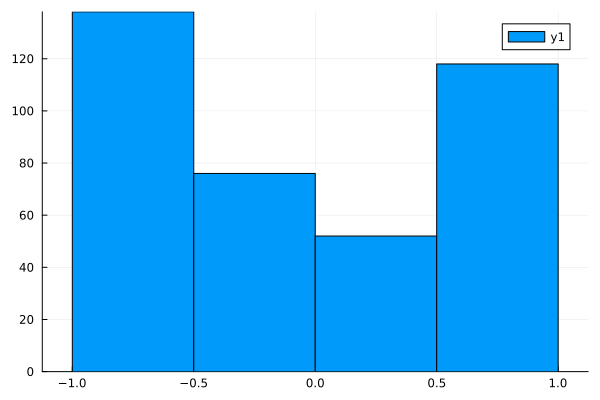

In [36]:
histogram(y_naive |> vec)

In [37]:
using Statistics: std, median, mean

In [38]:
using OneHotArrays

In [39]:
function get_truth(pt, threshold::Real = 0.2)
    return 1 .* (pt .> threshold) .+ 2 .* (pt .< -threshold)
end

get_truth (generic function with 2 methods)

In [40]:
function momentum_to_label(pt, threshold::Real = 0.2)
    y = onehotbatch(get_truth(pt, threshold), (0, 1, 2))
    return y
end

momentum_to_label (generic function with 2 methods)

In [41]:
labels = momentum_to_label(pt)

3×99991 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  1  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 1  1  ⋅  1  1  ⋅  1  1  ⋅  ⋅  1  1  ⋅     1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  1  1  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  1  ⋅  ⋅  ⋅

In [42]:
function loss(x, xl, y, model, ps, st, threshold)
    y_pred, st = model(process_inputs(x, xl), ps, st)
    y = momentum_to_label(y, threshold)
    loss = quadrature_loss(y_pred, y) |> mean
    return loss, st
end

loss (generic function with 1 method)

In [43]:
l0, st0 = @time loss(x, xl, y, model, ps, st, 0.2)

  0.156396 seconds (582.63 k allocations: 46.736 MiB, 7.13% gc time, 99.20% compilation time)


(1.361679508148608, (layer_1 = (running_mean = [2.7343750407453623e-5, 0.011720312674646264, 0.158769846115855, 1.0494967656387197, 3.214049110393063, 4.16443265580488, 3.6319093041196675, 1.1148337041123164, 0.11779922050534516, -0.004528312567477114, -0.00042331250630784777, 0.0, 0.0, 0.07180550185123537], running_var = [0.9000008921638939, 1.0404967775678888, 4.9352839507701995, 44.36456898678814, 214.18895577466316, 280.3147835280541, 244.4854051874365, 56.37100367649326, 5.12052608225659, 0.9041690609789671, 0.90022934380656, 0.8999999761581421, 0.8999999761581421, 2.9173396135808085], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [44]:
l0

1.361679508148608

In [45]:
function train(model, ps, st, train_loader, threshold::Real = 0.2; kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    device = cpu

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt_state = Optimisers.setup(Adam(3e-4), ps)
    losses = []

    ## Training
    for epoch in 1:args.epochs
        epoch_losses = []
        for (x, xl, y) in train_loader
            (loss_val, st), gs = withgradient(p -> loss(x, xl, y, model, p, st, threshold), ps)
            append!(epoch_losses, loss_val)
            opt_state, ps = Optimisers.update(opt_state, ps, gs[1]) ## update parameters
        end
        append!(losses, mean(epoch_losses))
    end

    return losses, ps, st
end

train (generic function with 2 methods)

In [46]:
@time loss_history, pst, stt = train(model, ps, st, train_loader, 0.2, epochs = 5)

[ Info: Constructing model and starting training


 39.404452 seconds (41.01 M allocations: 144.262 GiB, 15.71% gc time, 32.64% compilation time: <1% of which was recompilation)


(Any[0.361762073859551, 0.20601299946153698, 0.19947192490809476, 0.19144424919801323, 0.18522684992982696], (layer_1 = (scale = Float32[0.94766945, 1.0200474, 1.0080928, 0.9071987, 1.1200871, 0.85243744, 1.1039066, 1.0880357, 1.0622436, 0.7271087, 0.699433, 0.88765657, 0.8011488, 0.28768685], bias = Float32[-0.07944097, -0.040372886, 0.057647318, 0.295794, 0.011687726, 0.17731874, -0.09633987, 0.16822088, -0.088599645, -0.016848983, 0.009394613, 0.09477714, -0.064789206, 0.12654647]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.036571644 0.10342837 … -0.013026166 -0.116893; -0.1231677 0.045066502 … 0.08829288 -0.09052951; … ; 0.110651135 -0.18201007 … -0.05108299 -0.022416167; 0.062476017 -0.06807702 … 0.044632692 -0.1162501], bias = ComplexF32[1.0073818f0 + 0.01707949f0im, 1.0129353f0 + 0.009437937f0im, 0.9993685f0 - 0.01733718f0im, 1.0119526f0 - 0.045299668f0im, 0.99740136f0 + 0.06295349f0im, 0.97817403f0 - 0.024789965f0im, 0.9831844f0 + 0.005375393f0im, 0.9979576f0 + 0.0

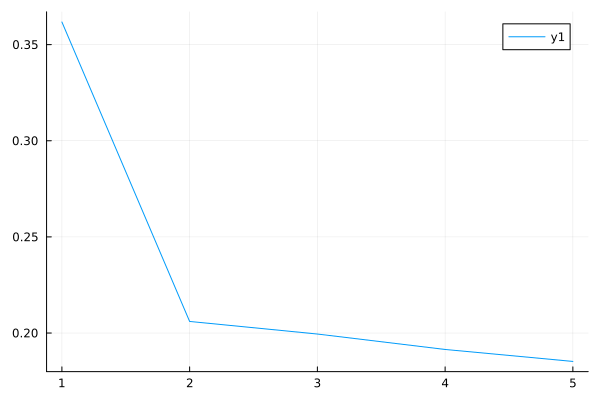

In [47]:
plot(loss_history)

In [48]:
loss(x, xl, y, model, pst, stt, 0.2)[1]

0.1886641175816092

In [49]:
loss_history2, pst2, stt2 = train(model, pst, stt, train_loader, 0.2, epochs = 95)

[ Info: Constructing model and starting training


(Any[0.18183971661831672, 0.18015476356041968, 0.1787369899715509, 0.1773462609782276, 0.1761449830547002, 0.1751809850550699, 0.17429887200490854, 0.17359685422114704, 0.17295535415320085, 0.17239530916272916  …  0.16148046900544366, 0.16140995992915533, 0.1613971687075338, 0.1613879767014839, 0.1612996841557242, 0.16123126289335696, 0.1611577733625841, 0.16115509045574858, 0.16101542672163408, 0.1609820402274188], (layer_1 = (scale = Float32[0.15501237, 0.9912842, 1.0376749, 0.9981167, 0.9821746, 0.71990055, 1.0455918, 1.1359345, 1.0881348, 0.14166708, 0.19892232, 0.10488607, 0.12268295, 0.28786916], bias = Float32[-0.19661261, -0.051186997, 0.2846033, 0.5714588, 0.11736421, 0.46912143, 0.07107086, 0.37284824, -0.025322052, 0.03132852, -0.025861073, 0.14577876, -0.14864698, 0.31098616]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.04439177 0.080579616 … -0.027973257 -0.1044244; -0.1389826 0.10410588 … 0.101996675 -0.12098375; … ; -0.022222199 -0.23511289 … -0.11001974 -0.2

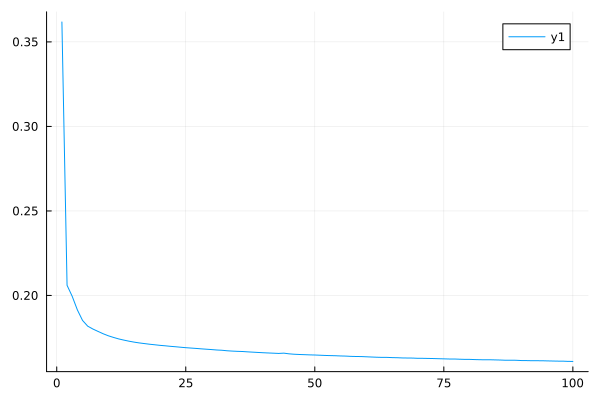

In [50]:
plot(vcat(loss_history, loss_history2))

In [51]:
pst = pst2

(layer_1 = (scale = Float32[0.15501237, 0.9912842, 1.0376749, 0.9981167, 0.9821746, 0.71990055, 1.0455918, 1.1359345, 1.0881348, 0.14166708, 0.19892232, 0.10488607, 0.12268295, 0.28786916], bias = Float32[-0.19661261, -0.051186997, 0.2846033, 0.5714588, 0.11736421, 0.46912143, 0.07107086, 0.37284824, -0.025322052, 0.03132852, -0.025861073, 0.14577876, -0.14864698, 0.31098616]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.04439177 0.080579616 … -0.027973257 -0.1044244; -0.1389826 0.10410588 … 0.101996675 -0.12098375; … ; -0.022222199 -0.23511289 … -0.11001974 -0.2411597; 0.046987724 -0.039151445 … 0.063200235 -0.23334558], bias = ComplexF32[1.0091916f0 + 0.04508992f0im, 1.0287935f0 + 0.03403925f0im, 0.97664535f0 + 0.021805443f0im, 0.9759874f0 - 0.21786824f0im, 1.0030189f0 + 0.067971446f0im, 0.85503334f0 - 0.07347467f0im, 0.9474933f0 + 0.05316603f0im, 1.0135418f0 - 0.026384188f0im, 0.9506506f0 - 0.059696235f0im, 1.0144364f0 - 0.006221492f0im  …  0.9922957f0 - 0.0735431f0im, 1.

In [52]:
sttf = Lux.testmode(stt2)

(layer_1 = (running_mean = [0.5757944121368425, 0.6846214445057881, 3.877447210797926, 16.457718797941705, 40.50550733079511, 46.45902297891875, 34.455593553787885, 11.694720261830742, 1.4321486865495832, 0.27754491012521154, 0.20938791166720094, 0.09354000307185677, 0.11033681559878909, 0.15291454619067543], running_var = [45.4440043349743, 30.597847176643445, 142.5825230347542, 785.3730588946706, 2787.8957479624682, 2453.057413839121, 2345.648527495587, 722.0711161220706, 91.57263090145504, 19.209888472669824, 10.95922934152389, 2.537559208572711, 11.005162970582472, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple())

In [53]:
loss(x, xl, y, model, pst, sttf, 0.2)

(0.14573614313764854, (layer_1 = (running_mean = [0.5757944121368425, 0.6846214445057881, 3.877447210797926, 16.457718797941705, 40.50550733079511, 46.45902297891875, 34.455593553787885, 11.694720261830742, 1.4321486865495832, 0.27754491012521154, 0.20938791166720094, 0.09354000307185677, 0.11033681559878909, 0.15291454619067543], running_var = [45.4440043349743, 30.597847176643445, 142.5825230347542, 785.3730588946706, 2787.8957479624682, 2453.057413839121, 2345.648527495587, 722.0711161220706, 91.57263090145504, 19.209888472669824, 10.95922934152389, 2.537559208572711, 11.005162970582472, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [54]:
loss_history[end]

0.18522684992982696

In [55]:
yt, _ = model(process_inputs(x, xl), pst, stt)

([0.026691152864456637 0.00866217196519961 … 0.023577198324656122 0.013547509006163888; 0.41793954510826536 0.11054243367468075 … 0.17768360813113518 0.27429723770762315; -0.014674634329033162 0.33590383929422635 … 0.23947470207462507 0.16807835167332844], (layer_1 = (running_mean = [0.5182423009455571, 0.6278795964072084, 3.648472243388443, 15.861443291403662, 39.669004742382114, 45.977552229162335, 34.641942681043396, 11.640081660936126, 1.4067330042548845, 0.24526209992802694, 0.18802580300197616, 0.08418600053450363, 0.0993031314082755, 0.2094285897770764], running_var = [40.899603734013134, 27.67855853087932, 132.3595513064586, 750.3003032910807, 2722.395062496112, 2487.166397521659, 2354.6690240326875, 705.3349909946818, 86.63589173414633, 17.293068252224234, 9.86353551373153, 2.283803227215314, 9.904646411140693, 19.978280087850898], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

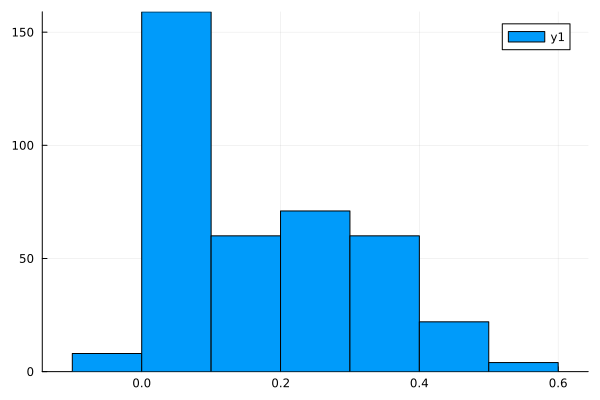

In [56]:
histogram(yt |> vec)

# Calculate the Test Loss

In [57]:
xts, xlts, yts = first(test_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [58]:
function accuracy(x, xl, y, model, ps, st, threshold::Real)
    y_truth = get_truth(y, threshold)
    y_pred, _ = model(process_inputs(x, xl), ps, st)
    #predict & correct for zero indexing
    y_labels = predict_quadrature(y_pred) .- 1
    right = sum(y_truth .== y_labels)
    return right
end

accuracy (generic function with 1 method)

In [59]:
yth, _ = model(process_inputs(q_test[:,:,:,1:10000], ylocal_test[1:10000]), pst, sttf)

([0.0067276357085157374 0.015081826328032307 … 0.012049736172890289 0.017179667074590194; -0.06705241675564194 0.07234380222676193 … 0.013441188314001486 0.17976068598578676; 0.4527678620692017 0.385086940307419 … 0.4015807374960636 0.2682565574439148], (layer_1 = (running_mean = [0.5757944121368425, 0.6846214445057881, 3.877447210797926, 16.457718797941705, 40.50550733079511, 46.45902297891875, 34.455593553787885, 11.694720261830742, 1.4321486865495832, 0.27754491012521154, 0.20938791166720094, 0.09354000307185677, 0.11033681559878909, 0.15291454619067543], running_var = [45.4440043349743, 30.597847176643445, 142.5825230347542, 785.3730588946706, 2787.8957479624682, 2453.057413839121, 2345.648527495587, 722.0711161220706, 91.57263090145504, 19.209888472669824, 10.95922934152389, 2.537559208572711, 11.005162970582472, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [60]:
accuracy(q_test[:,:,:,1:10000], ylocal_test[1:10000], pt_test[1:10000], model, pst, sttf, 0.2)

7132

In [61]:
using LinearAlgebra: diag

In [62]:
roc = tpr_fpr(yth, pt_test[1:10000])

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [63]:
roc_fn = interpolate_roc(roc)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    203-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.0
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/91PhN/src/gridded/gridded.jl:77


203-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

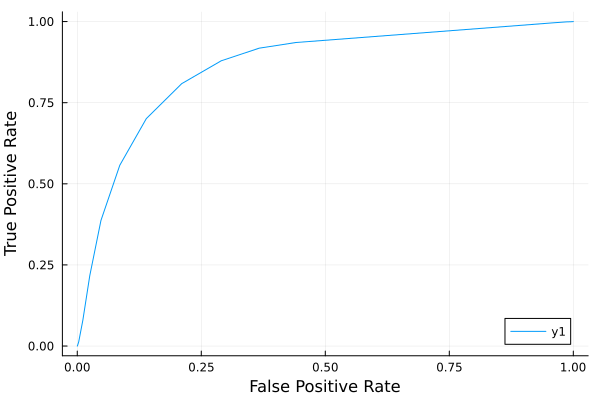

In [64]:
plot(roc[2], roc[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [65]:
auc, _ = quadgk(roc_fn, 0.0, 1.0)

(0.8606765479182434, 1.2154493217628816e-8)